In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, time, json
import pandas as pd
from openai import OpenAI
from tqdm.auto import tqdm
import spacy

import sys
sys.path.append("../")
import os

import logging
from src.utils import logging_utils
from src.utils import env_utils
from src import functional

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}")
logger.info(f"{transformers.__version__=}")

/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2024-08-30 11:43:15 __main__ INFO     torch.__version__='2.3.1', torch.version.cuda='12.1'
2024-08-30 11:43:15 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=1, torch.cuda.get_device_name()='NVIDIA RTX A6000'
2024-08-30 11:43:15 __main__ INFO     transformers.__version__='4.44.2'


In [80]:
def get_location(key: str):
    return key.split("_<>_")

def get_average_indirect_effects(indirect_effects: list[dict], query_start: list[int] = None):
    """Will average the contributions of heads across all examples and different token positions"""
    if query_start is None:
        query_start = [0] * len(indirect_effects)
    else:
        assert len(query_start) == len(indirect_effects)

    modules = list(set([get_location(key)[0] for key in indirect_effects[0].keys()]))
    aie = {key: 0 for key in modules}
    for ie, st in zip(indirect_effects, query_start):
        for key in ie.keys():
            module_name, token_idx = get_location(key)
            # print(f"{module_name=}, {token_idx=} | {st=}")
            if int(token_idx) < st:
                print(f"{token_idx=} < {st=} .. skipping") # seems like I am just saving after the query start
                continue
            assert module_name in modules
            aie[module_name] += ie[key]
    for key in aie.keys():
        aie[key] /= len(indirect_effects)
    return aie

def get_head_matrix_for_plotting(aie):
    layer_name_format = "model.layers.{}"
    attn_head_name_format = ".self_attn.{}"

    head_aie_matrix = torch.zeros((32, 32))
    for l in range(32):
        layer = layer_name_format.format(l)
        for h in range(32):
            attn_head = layer + attn_head_name_format.format(h)
            head_aie_matrix[l, h] = aie[attn_head]
    return head_aie_matrix

# aie = get_average_indirect_effects(
#     [d["indirect_effects"] for d in dct["attribution_patching_results"]]
# )

In [81]:
import numpy as np

model_key = "meta-llama/Meta-Llama-3-8B-Instruct"
results_dir = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "attribution_patching",
    model_key.split("/")[-1],
)

relations = os.listdir(results_dir)

dct_relations = {}
for relation in relations:
    with open(os.path.join(results_dir, f"{relation}/{relation}.json")) as f:
        dct_relations[relation] = json.load(f)

# print(dct.keys())
# dct["attribution_patching_results"][0].keys()

In [82]:
relation = "sport_players"
dct = dct_relations[relation]

In [83]:
dct["attribution_patching_results"][0]["query_start"]

49

2024-08-30 16:39:30 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fd7ef1a3790>


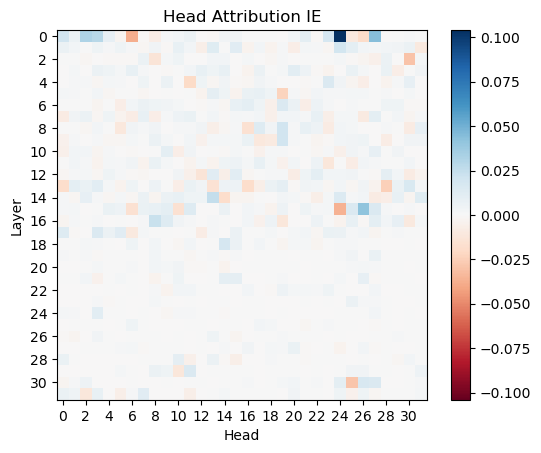

In [84]:
from src.plotting import matrix_heatmap

indirect_effects = []
query_start_indices = []
for relation in relations:
    dct = dct_relations[relation]
    indirect_effects.extend([d["indirect_effects"] for d in dct["attribution_patching_results"]])
    query_start_indices.extend([d["query_start"] for d in dct["attribution_patching_results"]])

aie = get_average_indirect_effects(
    # [d["indirect_effects"] for d in dct["attribution_patching_results"]]
    indirect_effects,
    query_start = query_start_indices
)
head_aie_matrix = get_head_matrix_for_plotting(aie)

matrix_heatmap(
    matrix = head_aie_matrix,
    x_label="Head",
    y_label="Layer",
    tick_gap=2,
    title="Head Attribution IE",
)

2024-08-30 16:39:30 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fd7f94551d0>


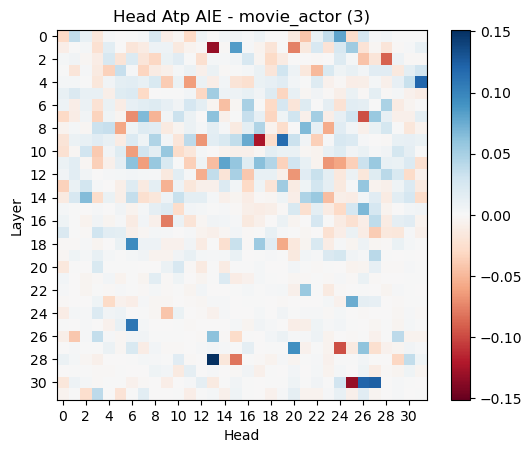

2024-08-30 16:39:31 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fd7f9513a50>


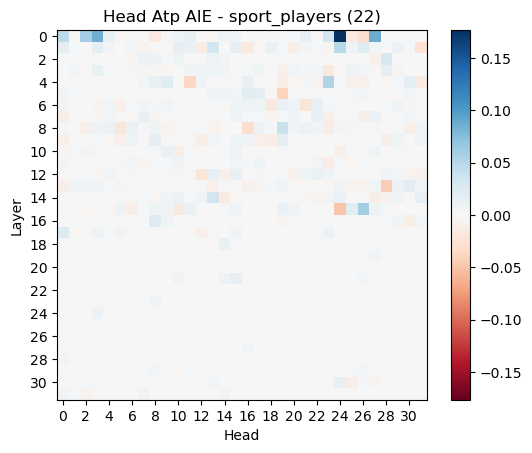

2024-08-30 16:39:33 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fd7f9630790>


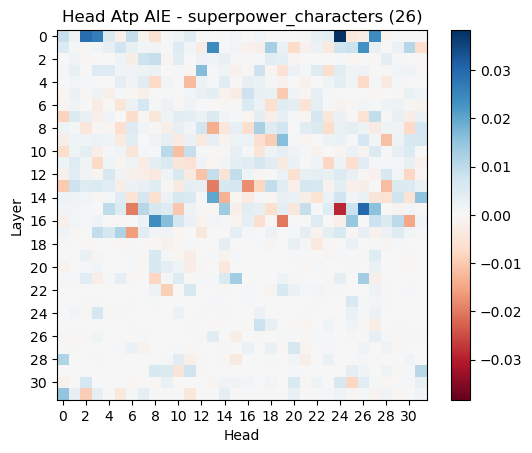

2024-08-30 16:39:35 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fd7f9471310>


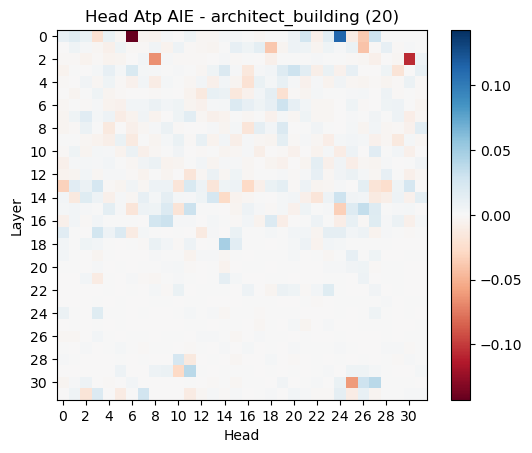

In [85]:
for relation in relations:
    dct = dct_relations[relation]
    aie = get_average_indirect_effects(
        [d["indirect_effects"] for d in dct["attribution_patching_results"]]
    )
    head_aie_matrix = get_head_matrix_for_plotting(aie)

    matrix_heatmap(
        matrix = head_aie_matrix,
        x_label="Head",
        y_label="Layer",
        tick_gap=2,
        title=f"Head Atp AIE - {relation} ({len(dct['attribution_patching_results'])})",
    )

In [89]:
dct = dct_relations["sport_players"]

atp_results = dct["attribution_patching_results"]
atp_result = atp_results[0]
query_start = atp_result["query_start"]
clean_toks = atp_result["clean_toks"][query_start:]
patch_toks = atp_result["patch_toks"][query_start:]

list(zip(clean_toks, patch_toks))

[('What', 'What'),
 (' is', ' is'),
 (' a', ' a'),
 (' common', ' common'),
 (' link', ' link'),
 (' between', ' between'),
 ('<|end_of_text|>', ' Michael'),
 ('<|end_of_text|>', ' Sch'),
 (' Michael', 'um'),
 (' Vaughan', 'acher'),
 (' and', ' and'),
 (' Sour', '<|end_of_text|>'),
 ('av', '<|end_of_text|>'),
 (' Gang', ' Lewis'),
 ('uly', ' Hamilton'),
 ('?\n', '?\n'),
 ('A', 'A'),
 (':', ':')]

56